In [10]:
%load_ext autoreload
%autoreload 2
from new_aeb_gplvm import *
import warnings
import json
import random
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.distributions import kl_divergence

warnings.filterwarnings("ignore")
# import the necessary package
from tqdm import trange
from utils.data_generator import DataGenerator
from utils.myutils import Utils
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange

datagenerator = DataGenerator()  # data generator
utils = Utils()  # utils function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
dataset_list = os.listdir("datasets/Classical")


def fix_name(name):
    fixed = name.replace(".npz", "")
    return fixed


datasets = list(map(fix_name, dataset_list))

In [12]:
df_hyper = pd.read_json("experiments/complete/gplvm/000_gplvm_normal_03_best.json")

In [13]:
def get_hypers(dataset):
    hypers = df_hyper[df_hyper.dataset == dataset]
    hp = hypers[
        [
            "kernel",
            "batch_size",
            "learning_rate",
            "latent_dim",
            "layers",
            "n_inducing",
            "n_epochs",
        ]
    ].to_dict(orient="records")
    return hp[0]

In [14]:
from baseline.PyOD import PYOD

model_dict = {"GPLVM": AD_GPLVM}
dataset = datasets[29]
dataset

'30_satellite'

In [15]:
methods = ["refine", "soft"]
labeled_anomalies = [0.15, 0.75]

In [ ]:
for dataset in datasets:
    for la in labeled_anomalies:
        seed = 42
        # df_AUCROC = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())
        # df_AUCPR = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())

        datagenerator.dataset = dataset  # specify the dataset name
        data = datagenerator.generator(
            la=la,
            realistic_synthetic_mode=None,
            noise_type=None,
            stdscale=True,
            minmax=False,
        )
        true_ratio = data["y_test"].sum() / len(data["y_test"])
        Y_train, Y_test, lb_train, lb_test = (
            data["X_train"],
            data["X_test"],
            data["y_train"],
            data["y_test"],
        )
        for method in methods:
            try:
                hp = get_hypers(dataset)
                aucroc = []
                aucpr = []
                for i in range(5):
                    clf = AD_GPLVM(
                        latent_dim=hp["latent_dim"],
                        n_inducing=hp["n_inducing"],
                        n_epochs=120,  # hp["n_epochs"],
                        nn_layers=tuple(map(int, hp["layers"].split(","))),
                        lr=hp["learning_rate"],
                        batch_size=hp["batch_size"],
                        kernel=hp["kernel"],
                    )
                    clf.fit(Y_train, lb_train, loss_type=method)
                    score = clf.predict_score(Y_test)
                    result = utils.metric(y_true=lb_test, y_score=score)
                    aucroc.append(result["aucroc"])
                    aucpr.append(result["aucpr"])
    
                result["aucroc"] = np.mean(aucroc)
                result["aucpr"] = np.mean(aucpr)
            except Exception as e:
                print(f"problema no {dataset}")
                result["aucroc"] = 0.0
                result["aucpr"] = 0.0
            result["dataset"] = dataset
            result["method"] = method
            result["test_ratio"] = true_ratio
            result["train_ratio"] = la * true_ratio
            result["labeled_anomalies"] = la
            result["loe_loss"] = clf.loe_list

            with open(
                f"experiments/complete/loe/{dataset}_{str(int(la*100))}_{method}.json",
                "w",
            ) as file:
                json.dump(result, file)

subsampling for dataset 01_ALOI...
subsampling for dataset 01_ALOI...
subsampling for dataset 03_backdoor...
subsampling for dataset 03_backdoor...
generating duplicate samples for dataset 04_breastw...
generating duplicate samples for dataset 04_breastw...
subsampling for dataset 05_campaign...


In [6]:
# seed for reproducible results
seed = 42
df_AUCROC = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())
df_AUCPR = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())
# import the dataset
datagenerator.dataset = dataset  # specify the dataset name
data = datagenerator.generator(
    la=1.00,
    realistic_synthetic_mode=None,
    noise_type=None,
    stdscale=True,
    minmax=False,
)
ratio = data["y_train"].sum() / len(data["y_train"])
Y_train, Y_test, lb_train, lb_test = (
    data["X_train"],
    data["X_test"],
    data["y_train"],
    data["y_test"],
)

In [52]:
hp = get_hypers(dataset)
hp

{'kernel': 'rbf',
 'batch_size': 128,
 'learning_rate': 0.01,
 'latent_dim': 7,
 'layers': '15,15',
 'n_inducing': 25,
 'n_epochs': 1000}

In [219]:
clf = AD_GPLVM(
    latent_dim=hp["latent_dim"],
    n_inducing=hp["n_inducing"],
    n_epochs=130,  # hp["n_epochs"],
    nn_layers=tuple(map(int, hp["layers"].split(","))),
    lr=hp["learning_rate"],
    batch_size=hp["batch_size"],
    kernel=hp["kernel"],
)

In [220]:
dataset

'30_satellite'

In [221]:
clf.fit(Y_train, lb_train, loss_type="soft")
score = clf.predict_score(Y_test)
result = utils.metric(y_true=lb_test, y_score=score)

In [250]:
clf.loe_list

[60.68409729003906,
 47.58724594116211,
 49.152469635009766,
 43.922943115234375,
 51.829891204833984,
 46.37474822998047,
 44.01054382324219,
 49.823001861572266,
 40.24319076538086,
 37.57999801635742,
 47.003395080566406,
 47.1353874206543,
 45.51139831542969,
 43.372886657714844,
 46.51393508911133,
 43.97848129272461,
 40.49623107910156,
 40.78010940551758,
 40.69686508178711,
 36.373779296875,
 42.91020584106445,
 41.11009216308594,
 44.85222625732422,
 39.920005798339844,
 32.912086486816406,
 41.098716735839844,
 39.71147155761719,
 39.92133331298828,
 40.02978515625,
 41.41733932495117,
 43.27721405029297,
 40.49818420410156,
 38.867897033691406,
 37.93471145629883,
 37.9348258972168,
 39.03712463378906,
 40.581729888916016,
 46.51536560058594,
 38.31963348388672,
 42.80100631713867,
 37.85041809082031,
 37.99958038330078,
 35.93479537963867]

In [223]:
result

{'aucroc': 0.752337201805287, 'aucpr': 0.7092488880314904}

In [224]:
clf.i

122

In [ ]:
clf.loe_list

In [135]:
# clf.lll.sum(), clf.klu.sum(), clf.klx.sum()

In [136]:
# elbo = VariationalELBO(clf.likelihood, clf.model, len(Y_train), combine_terms=False)

In [137]:
# elbo(clf.pred, clf.batch)[0].sum(),elbo(clf.pred, clf.batch)[1].sum(), elbo(clf.pred, clf.batch)[3].sum()

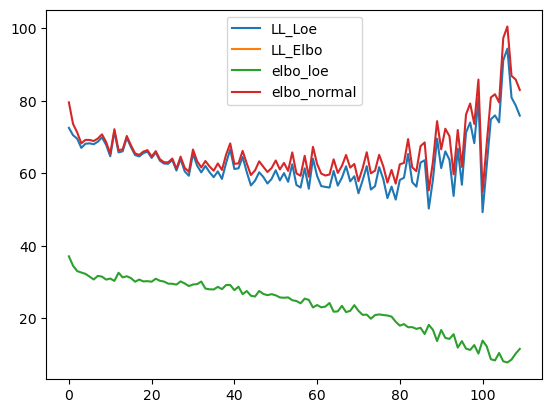

In [184]:
plt.plot(
    clf.lll_loe,
    label="LL_Loe",
)
plt.plot(
    clf.lll_elbo,
    label="LL_Elbo",
)
# plt.plot(
#    clf.klx_loe,
#    label="KLX_Loe",
# )
# plt.plot(
#    clf.klx_elbo,
#    label="KLX_Elbo",
# )
# plt.plot(
#    clf.klu_loe,
#    label="KLU_Loe",
# )
# plt.plot(
#    clf.klu_elbo,
#    label="KLU_Elbo",
# )
plt.plot(
    clf.loe_list,
    label="elbo_loe",
)
plt.plot(
    clf.loss_list,
    label="elbo_normal",
)
plt.legend()
None

In [101]:
clf.elbo(clf.pred, clf.batch).sum()

tensor(-8.6120, grad_fn=<SumBackward0>)

In [132]:
kl_divergence(clf.encoder.kl_latent.q_x, clf.encoder.kl_latent.p_x).sum(axis=0) / (
    clf.encoder.kl_latent.n
)

tensor(0.1080, grad_fn=<DivBackward0>)

In [122]:
Y_train = torch.tensor(Y_train, dtype=torch.float32)
sample = clf.model.sample_latent_variable(Y_train)
output = clf.model(sample)

In [123]:
clf.elbo(output, Y_train.T).sum()

tensor(-42.5673, grad_fn=<SumBackward0>)

In [124]:
elbo_x = VariationalELBO(clf.likelihood, clf.model, len(Y_train), combine_terms=False)

In [125]:
ll, klu, _, klx = elbo_x(output, Y_train.T)
{
    "log_likelihood": ll,
    "ll_sum": ll.sum(),
    "klx": klx,
    "klx_sum": klx.sum(),
    "klu": klu,
    "klu_sum": klu.sum(),
    "total_sum": ll.sum() - klx.sum() - klu.sum(),
}

{'log_likelihood': tensor([-1.5695, -1.5708, -1.5703, -1.5700, -1.5688, -1.5696, -1.5694, -1.5694,
         -1.5697, -1.5705, -1.5697, -1.5696, -1.5700, -1.5695, -1.5694, -1.5696,
         -1.5691, -1.5698, -1.5701, -1.5699, -1.5698, -1.5706, -1.5703, -1.5698,
         -1.5695, -1.5698, -1.5698], grad_fn=<DivBackward0>),
 'll_sum': tensor(-42.3843, grad_fn=<SumBackward0>),
 'klx': tensor([0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
         0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
         0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040],
        grad_fn=<AddBackward0>),
 'klx_sum': tensor(0.1080, grad_fn=<SumBackward0>),
 'klu': tensor([0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0027, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028],
        grad_fn=<DivBackward0>),
 'kl

In [127]:
log_likelihood = (
    clf.likelihood.expected_log_prob(Y_train.T, output).sum(0).div(len(Y_train))
)
{
    "log_likelihood": log_likelihood,
    "log_likelihood_sum": log_likelihood.sum(),
}

{'log_likelihood': tensor([-0.0045, -0.0045, -0.0048,  ..., -0.0044, -0.0042, -0.0050],
        grad_fn=<DivBackward0>),
 'log_likelihood_sum': tensor(-42.3843, grad_fn=<SumBackward0>)}

In [128]:
klu_expanded = clf.model.variational_strategy.kl_divergence().div(len(Y_train))
{
    "klu_expanded": klu_expanded,
    "klu_expanded_sum": klu_expanded.sum(),
}

{'klu_expanded': tensor([0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0027, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028],
        grad_fn=<DivBackward0>),
 'klu_expanded_sum': tensor(0.0750, grad_fn=<SumBackward0>)}

In [45]:
klu_zero = torch.zeros_like(Y_train)
klu_zero

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [54]:
added_loss = torch.zeros_like(log_likelihood)
for added_loss_term in clf.model.added_loss_terms():
    added_loss.add_(added_loss_term.loss())
added_loss.sum()

tensor(26.7473, grad_fn=<SumBackward0>)

In [24]:
contamination = lb_train.sum() / len(lb_train)

In [39]:
loss_n, _ = torch.topk(
    torch.tensor(score),
    int(score.shape[0] * (1 - contamination)),
    largest=False,
    sorted=False,
)
loss_a, _ = torch.topk(
    torch.tensor(score),
    int(score.shape[0] * (contamination)),
    largest=True,
    sorted=False,
)